In [1]:
import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")

# set working directory to root 
import os
os.chdir("../../")
print(os.getcwd())

/home/simonjasansky/programming/mine-segmentation


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from matplotlib.colors import ListedColormap

from src.models.clay.segment.datamodule import MineDataModule
from src.models.clay.segment.model import MineSegmentor

### Define paths and parameters

In [3]:
MINESEG_CHECKPOINT_PATH = (
    "models/mineseg-2class-segment_epoch-05_val-iou-0.9047.ckpt"
)
CLAY_CHECKPOINT_PATH = "models/clay-v1-base.ckpt"
METADATA_PATH = "configs/clay_segment_metadata.yaml"

TRAIN_CHIP_DIR = "data/processed/chips/train/chips/"
TRAIN_LABEL_DIR = " data/processed/chips/train/labels/"
VAL_CHIP_DIR = "data/processed/chips/val/chips/"
VAL_LABEL_DIR = "data/processed/chips/val/labels/"

BATCH_SIZE = 1
NUM_WORKERS = 1
PLATFORM = "sentinel-2-l2a"

### Model Loading

In [4]:
def get_model(mineseg_checkpoint_path, clay_checkpoint_path, metadata_path):
    model = MineSegmentor.load_from_checkpoint(
        checkpoint_path=mineseg_checkpoint_path,
        metadata_path=metadata_path,
        ckpt_path=clay_checkpoint_path,
    )
    model.eval()
    return model

### Data Preparation

In [5]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    index=None
):
    dm = MineDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
    )
    dm.setup(stage="fit")
    if index is not None:
        val_dl = iter(dm.val_dataloader())
        for i in range(index + 1):
            batch = next(val_dl)
        metadata = dm.metadata
        return batch, metadata
    else:
        val_dl = dm.val_dataloader()
        batch = next(iter(val_dl))
        metadata = dm.metadata
        return batch, metadata
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [6]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(512, 512), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [7]:
def post_process(batch, outputs, metadata):
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    # normalize and clip the image ranges
    pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())
    pixels = np.clip(pixels, 0, 1)

    images = pixels[0]
    labels = labels[0]
    preds = preds[0]

    images = images.transpose((1,2,0))

    return images, labels, preds

### Plotting

In [8]:
def plot_predictions(images, labels, preds):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Plot the image
    axes[0].imshow(images)
    axes[0].axis("off")
    axes[0].set_title("Image", fontsize=12)

    # Plot the actual segmentation
    axes[1].imshow(labels, vmin=0, vmax=6)
    axes[1].axis("off")
    axes[1].set_title("Actual", fontsize=12)

    # Plot the predicted segmentation
    axes[2].imshow(preds, vmin=0, vmax=6)
    axes[2].axis("off")
    axes[2].set_title("Pred", fontsize=12)

    plt.tight_layout()
    plt.show()

In [9]:
# Load model
model = get_model(MINESEG_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)

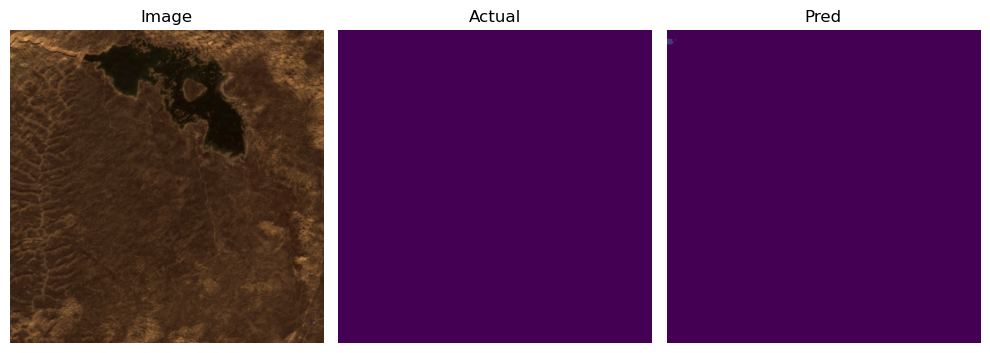

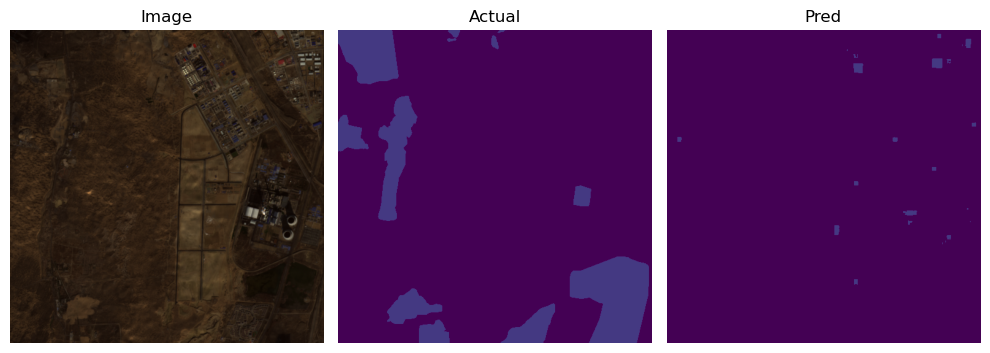

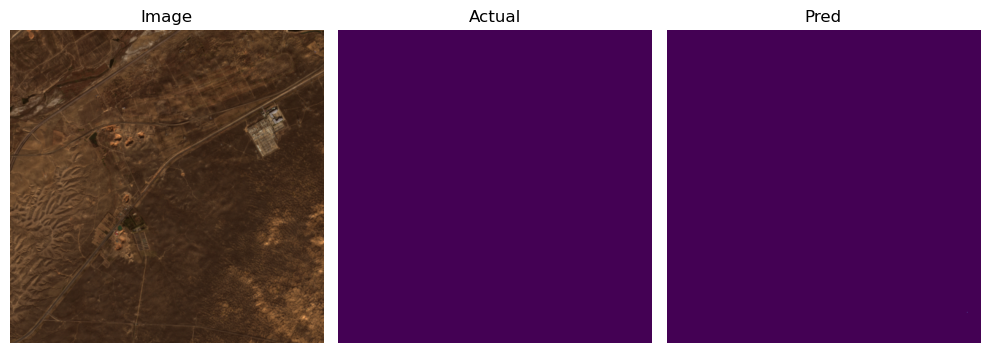

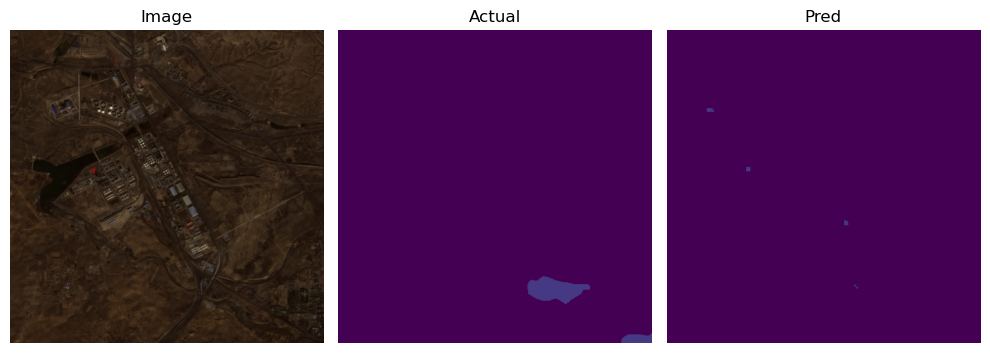

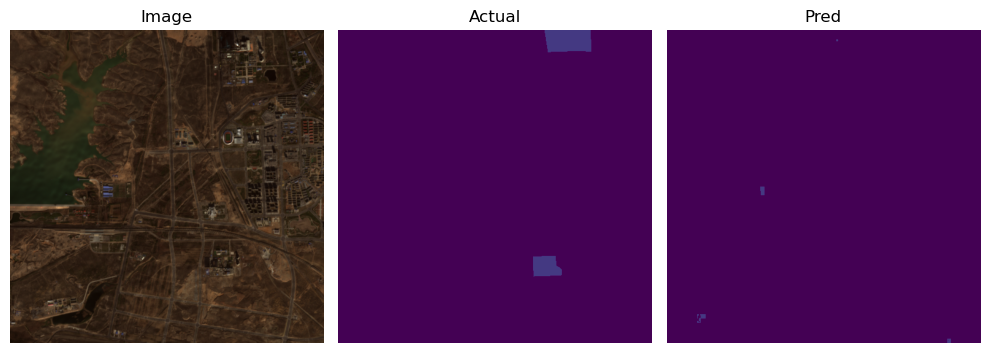

In [11]:
for index in range(5):

    # Get data
    batch, metadata = get_data(
        TRAIN_CHIP_DIR,
        TRAIN_LABEL_DIR,
        VAL_CHIP_DIR,
        VAL_LABEL_DIR,
        METADATA_PATH,
        BATCH_SIZE,
        NUM_WORKERS,
        PLATFORM,
        index=index
    )

    # Move batch to GPU
    if torch.cuda.is_available():
        batch = {k: v.to("cuda") for k, v in batch.items()}

    # Run prediction
    outputs = run_prediction(model, batch)

    # Post-process the results
    images, labels, preds = post_process(batch, outputs, metadata)

    # Plot the predictions
    plot_predictions(images, labels, preds)